In [1]:
!pip install tweepy
!pip install spacy
!pip install scikit-learn
!python -m spacy download es

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')
✔ Linking successful
/opt/conda/lib/python3.7/site-packages/es_core_news_sm -->
/opt/conda/lib/python3.7/site-packages/spacy/data/es
You can now load the model via spacy.load('es')


# **Librerias**

In [2]:
import tweepy
from tweepy import OAuthHandler
import csv
import re
from os import remove
from os import path
import pandas as pd
from tqdm import tqdm
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

# **Accediendo Con las Credenciales**

In [3]:
consumer_key= "Your keys.."
consumer_secret= "Your keys.."
access_token= "Your Token.."
access_token_secret= "Your Token.."

In [4]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

In [5]:
api = tweepy.API(auth, wait_on_rate_limit= True, wait_on_rate_limit_notify=True)

# **Manejo De Arcivo csv**

In [6]:
if path.exists("/kaggle/working/twitter.csv"):
    remove('/kaggle/working/twitter.csv')

In [7]:
# Open/create a file to append data to
csvFile = open('/kaggle/working/twitter.csv', 'a',encoding="utf_8_sig")

In [8]:
#Use csv writer
csvWriter = csv.writer(csvFile, lineterminator="\n",delimiter=";")

In [9]:
searchTerms= "#Covid -filter:retweets"

# **Extraccion de Tweets**
Con la siguiente linea de codigo se buscan los tweets y al mismo tiempo se almacenan dentro del archivo csv

In [10]:
for tweet in tqdm(tweepy.Cursor(api.search, 
                        q=(searchTerms),
                        tweet_mode="extended", #extraer el tweet mas extenso
                        include_entities='true',
                        lang = "es").items()):
    clean_tweet= re.sub(r"http\S+", "", tweet.full_text) #se elimina los http que salian al final del tweet
    csvWriter.writerow([tweet.created_at, clean_tweet])
    
csvFile.close()

#se detiene el conteo en cierto tiempo porque la Api de twitter hace un sleep (entre 13 a 15 min) pero despues reanuda.

16765it [1:30:48,  3.08it/s]


# **Dataframe**
Se pasan los archivos del csv a un Dataframe para tener mejor control de los datos

In [3]:
#Dataframe
data = pd.read_csv("./twitter.csv", names=['Date','Post'], sep=';')
data.head()

,Date,Post
0,2020-12-04 17:00:58,"Si el #COVID no nos hace quedar en casa, la de..."
1,2020-12-04 17:00:50,@claya1 @ChinoGabrielV1 @troll760 Pero ¿es aho...
2,2020-12-04 17:00:47,"Les recordamos que el #Covid no es un juego, s..."
3,2020-12-04 17:00:29,4 formas de proteger su #SaludMental durante l...
4,2020-12-04 17:00:02,La dosis diaria de información que necesitas c...


# **Tipo de datos**
Se convierten los tipos de datos

In [4]:
#Tipos de datos
data['Date'] = pd.to_datetime(data['Date']) 
data['Post']= data['Post'].astype(str)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16765 entries, 0 to 16764
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    16765 non-null  datetime64[ns]
 1   Post    16765 non-null  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 262.1+ KB


# **Tweets Por Dia**

In [6]:
data['Day']=data['Date'].dt.day
days = data['Day'].value_counts().rename_axis('Day').reset_index(name='Tweets')
days

,Day,Tweets
0,26,2667
1,27,1872
2,3,1872
3,2,1850
4,1,1789
5,25,1679
6,30,1609
7,28,1248
8,29,1158
9,4,1021


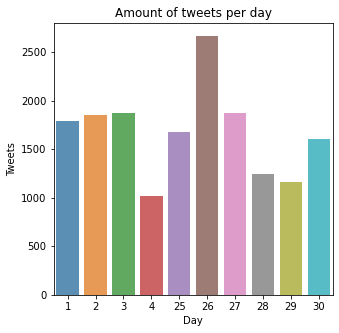

In [7]:
plt.figure(figsize=(5,5))
sns.barplot(days['Day'].values, days['Tweets'].values, alpha=0.8)
plt.title('Amount of tweets per day')
plt.ylabel('Tweets', fontsize=10)
plt.xlabel('Day', fontsize=10)
plt.show()

# **Extraccion de palabras**
Hacemos uso de la libreria spacy y los datos que contiene para cargar el modelo y de la misma forma tokenizar los tweets que se encuentran dentro del csv

In [8]:
nlp = spacy.load('es')#cargar modelo

words = {}
for row in tqdm(data['Post']):
    doc = nlp(row.lower())
    for token in doc:
        if token.is_alpha and not token.is_stop:
            if token.text in words:
                num_temp = int(words[token.text])
                words[token.text] = num_temp + 1
            else:
                words[token.text] = 1

100%|██████████| 16765/16765 [04:24<00:00, 63.40it/s]


# **Palabras**
Realizamos una separacion de las palabras con sus respectivas frecuencias, de la misma forma sumamos las veces que se repiten y ordenamos de mayor a menor la informacion para mostrar el top de las palabras mas usadas

In [9]:
del words['a']
del words['y']
df_words = pd.DataFrame([[key, words[key]] for key in words.keys()], columns=['Word', 'Freq'])
df_words.sort_values('Freq').tail(15)
df_words = df_words[:20]

#Ordenado Top 10
pr= df_words.groupby('Word').sum()
pr= pr.sort_values(by=['Freq'], ascending= False)
pr[['Freq']].head(10)

,Freq
Word,
covid,12716
casa,321
alemania,105
italia,55
familiar,53
ojo,33
hará,31
terrible,28
delincuencia,28


# **Analisis Visual**
Se representan las palabras mas usadas en una grafica comparativa para obtener una mejor visualizacion

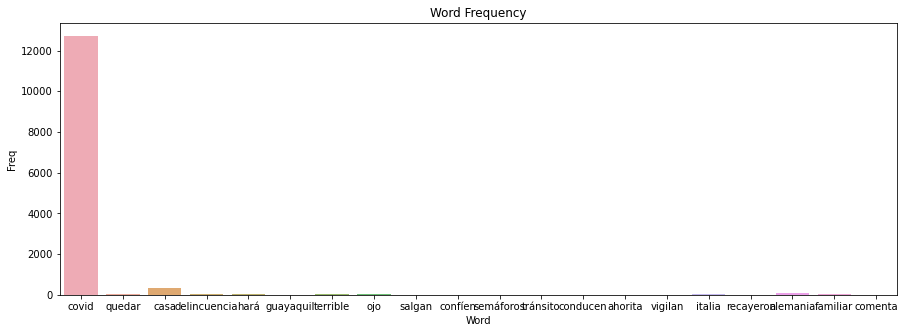

In [16]:
plt.figure(figsize=(15,5))
sns.barplot(df_words['Word'].values, df_words['Freq'].values, alpha=0.8)
plt.title('Word Frequency')
plt.ylabel('Freq', fontsize=10)
plt.xlabel('Word', fontsize=10)
plt.show()

# **Extraccion Partes del lenguaje**
Hacemos uso de la libreria spacy y los datos que contiene para cargar el modelo, de la misma forma tokenizar los tweets que se encuentran dentro del csv

In [10]:
#Uso frecuente de las partes del lenguaje dentro de los tweets
pos_freq = {}
for row in tqdm(data['Post'].to_list()):
    doc = nlp(row.lower())
    for token in doc:
        if token.pos_ in pos_freq:
            value = pos_freq[token.pos_]
            pos_freq[token.pos_] = value + 1
        else:
            pos_freq[token.pos_] =  1

100%|██████████| 16765/16765 [04:20<00:00, 64.34it/s]


# **Lenguaje**
Se identifica y se extraen la casificacion de las palabras dentro del lenguaje, es decir, a que grupo pertenece si es verbo,adverbio, etc.

In [11]:
df_pos = pd.DataFrame([[key, pos_freq[key]] for key in pos_freq.keys()], columns=['POS', 'Freq'])
df_pos.sort_values('Freq').tail(15)
df_pos = df_pos[:20]
df_pos.head(10)

,POS,Freq
0,SCONJ,10761
1,DET,54828
2,NOUN,94336
3,PROPN,120801
4,ADV,13820
5,PRON,12460
6,AUX,13552
7,VERB,44947
8,ADP,71980
9,PUNCT,45264


# **Analisis Visual**
Se representan las partes del lenguaje mas usadas en una grafica comparativa para obtener una mejor visualizacion.

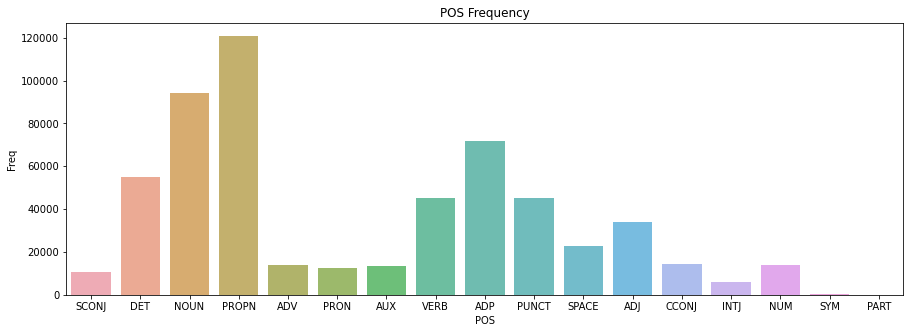

In [19]:
plt.figure(figsize=(15,5))
sns.barplot(df_pos['POS'].values, df_pos['Freq'].values, alpha=0.8)
plt.title('POS Frequency')
plt.ylabel('Freq', fontsize=10)
plt.xlabel('POS', fontsize=10)
plt.show()

# **Estadisticos Base**
Se hace un vision general o descripcion de los datos asi mismo como el calculo de las medias por cada palabra

In [20]:
#Describiendo el dataframe de frecuencia
df_words.describe()

,Freq
count,20.000000
mean,672.050000
std,2835.748327
min,1.000000
25%,3.750000
50%,15.000000
75%,38.000000
max,12716.000000


In [21]:
#Promedio de palabras
total= df_words["Freq"].sum()
promedio= (df_words.groupby('Word').sum())/total
orden= promedio
orden.columns= ["Promedio"]
orden= orden.sort_values(by=['Promedio'], ascending= False)
orden[['Promedio']].head(10)

,Promedio
Word,
covid,0.946061
casa,0.023882
alemania,0.007812
italia,0.004092
familiar,0.003943
ojo,0.002455
hará,0.002306
terrible,0.002083
delincuencia,0.002083


# **Transformacion**
Para el caso de TF-IDF tomamos del dataframe las posibles separaciones existentes de esta forma para facilitar el uso de los datos, el cual nos ayudara a obtener un dataframe de las palabras por cada uno de los tweets, para este caso se debio tomar todas las cadenas, incluyendo los simbolos para que se pudieran identificar algunas palabras que estaban dentro de contenian signos linguisticos

In [12]:
#Muestra de palabra en cada frase
v = CountVectorizer(stop_words=stopwords.words('spanish'))
x = v.fit_transform(data["Post"])
df1= pd.DataFrame(x.toarray(),columns= v.get_feature_names())
df1.head(20)

,00,000,0002,002,003,004,0040,005,008,009,...,𝘵𝘰𝘤𝘢𝘳,𝘼𝙇,𝙍𝙀𝙂𝙍𝙀𝙎𝘼,𝙎𝙀𝙂𝙐𝙍𝙊,𝙏𝙍𝘼𝘽𝘼𝙅𝙊,𝙏𝙚,𝙙𝙚,𝙫𝙖𝙨,𝙫𝙞𝙖𝙟𝙚,𝟣𝟫
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# **TF-IDF**
Con lo anterior, se aplico una funcion de python para calcular el TF-IDF, de este obtenemos datos reales, estos valores van segun la repeticion de una palabra en cada tweet donde en la columna index que enumera 0,1,2....n representa el numero de tweets y el valor que arroja es la repeticion de la palabra en ese tweet.

In [13]:
#TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords.words('spanish'))
y = tfidf_vectorizer.fit_transform(data["Post"])
df2= pd.DataFrame(y.toarray(), columns=tfidf_vectorizer.get_feature_names())
df2.head(20)

,00,000,0002,002,003,004,0040,005,008,009,...,𝘵𝘰𝘤𝘢𝘳,𝘼𝙇,𝙍𝙀𝙂𝙍𝙀𝙎𝘼,𝙎𝙀𝙂𝙐𝙍𝙊,𝙏𝙍𝘼𝘽𝘼𝙅𝙊,𝙏𝙚,𝙙𝙚,𝙫𝙖𝙨,𝙫𝙞𝙖𝙟𝙚,𝟣𝟫
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# **Grafica VS**
Grafica de un vs de las dos palabras mas usadas, tomando los valores de TF-IDF

In [14]:
#Tomando los datos mas repetidos
b= df_words.sort_values(by=['Freq'], ascending= False)
nuevo= b[:2].reset_index()
name1= nuevo["Word"][0]
name2= nuevo["Word"][1]

In [ ]:
ax = df2.plot(kind='scatter', x=name1, y=name2, alpha=0.1, s=300)
ax.set_xlabel(name1.upper())
ax.set_ylabel(name2.upper())